# Predicting the Price of NVIDIA Graphics Cards based on Performance Specifications

The goal of this project is to create a model which predicts the price of NVIDIA graphics cards using the availible performance specs. The data was scraped from www.newegg.com using 'web_scrape.py', which uses the BeautifulSoup package for html parsing. The project is split into 3 major parts. The first is cleaning the data up into a format we can use for analysis. The next is analysing the data and selecting relevant features. The final step is actually implementing a model and interpreting the result.

# 1. Cleaning up the data

The raw data from the website is very messy, there is incomplete data, data with units and data with other forms of text. 

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

df = pd.read_csv('graphics_data2.csv')

df

,Price,GPU,Core Clock,Boost Clock,CUDA Cores,Stream Processors,Memory Size,Memory Type,Memory Interface,Thermal Design Power
0,369.99,GeForce RTX 2060,NaN,1830 MHz,1920.0,NaN,6GB,GDDR6,192-Bit,190W
1,399.99,GeForce RTX 2070,1620 MHz,NaN,2304.0,NaN,8GB,GDDR6,256-Bit,120W
2,249.99,GeForce GTX 1660 SUPER,NaN,1815 MHz,1408.0,NaN,6GB,GDDR6,192-Bit,125W
3,739.99,GeForce RTX 2080 SUPER,NaN,1815 MHz,3072.0,NaN,8GB,GDDR6,256-Bit,250W
4,581.49,GeForce RTX 2070 SUPER,NaN,1770 MHz,2560.0,NaN,8GB,GDDR6,256-Bit,235W
...,...,...,...,...,...,...,...,...,...,...
175,446.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,239.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,79.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,560.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Special  Case: Clock speed
The data contains both Core Clock and Boost Clock, however some GPUs only have one or the other, or contain multiple values corresponding to overclocking and gaming mode etc.
I will take the maximum value of all of these options as it represents the maximum potential of the GPU.


In [96]:
def get_clock(array):
    try:
        x = [int(s) for s in array.split() if s.isdigit()]
        y = max(x)
    except:
        y = 0
    return y

column = []
for i in range(len(df['Core Clock'])):
    cc = df['Core Clock'][i]
    bc = df['Boost Clock'][i]
    
    cc = get_clock(cc)
    bc = get_clock(bc)
    
    column.append(max(cc, bc))
    

df['Clock'] = column
df = df.drop(columns=['Boost Clock', 'Core Clock'])

### Special Case: Series
This is the micro-architecture of the GPU chip and is given by the number of the GPU label e.g. GTX 1060. I've used 3 classes (1,2,3) to represent the series (900 series or less, 10 series, 20 series) respectively.

In [97]:
def get_series(array):
    try:
        x = [int(s) for s in array.split() if s.isdigit()]
        if x[0] < 1000:
            y = 1
        elif x[0] < 2000:
            y = 2
        else:
            y = 3
    except:
        y = 0
    return y


column = []
for i in range(len(df['GPU'])):
    column.append(get_series(df['GPU'][i]))
    
df['Series'] = column
df = df.drop(columns=['GPU'])

### Getting rid of units

In [98]:
def get_num(array):
    num = ''
    try:
        num = float(array)
    except:
        try:
            digits = [int(s) for s in array if s.isdigit()]
            for digit in digits:
                num += str(digit)
        except:
            num = 0 #returns 0 if the value is NULL
    return float(num)


for i in range(len(df.columns)):
    for j in range(len(df)):
        if df.isnull().iloc[j,i]:
            x = 0
        else:
            x = get_num(df.iloc[j,i])
        df.iloc[j,i] = x

In [99]:
df.to_csv('graphics_clean.csv', index=False)

df

,Price,CUDA Cores,Stream Processors,Memory Size,Memory Type,Memory Interface,Thermal Design Power,Clock,Series
0,369.99,1920.0,0,6,6,192,190,1830.0,3.0
1,399.99,2304.0,0,8,6,256,120,1620.0,3.0
2,249.99,1408.0,0,6,6,192,125,1815.0,2.0
3,739.99,3072.0,0,8,6,256,250,1815.0,3.0
4,581.49,2560.0,0,8,6,256,235,1770.0,3.0
...,...,...,...,...,...,...,...,...,...
175,446.86,0.0,0,0,0,0,0,0.0,0.0
176,239.88,0.0,0,0,0,0,0,0.0,0.0
177,79.99,0.0,0,0,0,0,0,0.0,0.0
178,560,0.0,0,0,0,0,0,0.0,0.0


# 2. Exploratory Data Analysis

In [100]:
df = pd.read_csv('graphics_clean.csv')

df.describe()

,Price,CUDA Cores,Stream Processors,Memory Size,Memory Type,Memory Interface,Thermal Design Power,Clock,Series
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,3692.140389,1414.755556,44.800000,5.033333,4.950000,166.933333,123.188889,1464.688889,2.033333
std,19840.086490,932.185446,314.838371,2.610465,1.926803,87.767697,88.397135,607.734278,0.956600
min,44.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,175.747500,896.000000,0.000000,4.000000,5.000000,128.000000,75.000000,1506.000000,2.000000
50%,299.990000,1408.000000,0.000000,6.000000,6.000000,192.000000,120.000000,1732.500000,2.000000
75%,480.330000,2176.000000,0.000000,8.000000,6.000000,256.000000,175.000000,1815.000000,3.000000
max,125000.000000,3072.000000,2816.000000,8.000000,6.000000,384.000000,650.000000,1905.000000,3.000000


From a quick look at these statistics we can immediately spot some outliers. The maximum value of price £125,000 which is clearly an error. The Stream Processors has an interquartile range of 0, which means that most of the values are missing. The box plots for these variables give a better idea of what's going on. Also I have replaced NULL values with 0 so these rows also need to be removed.

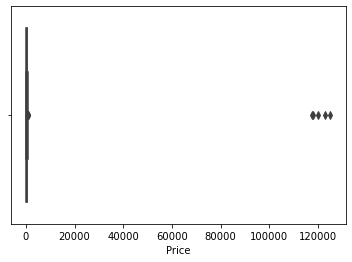

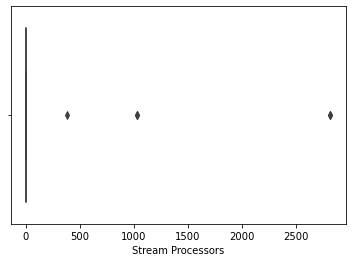

In [101]:
sns.boxplot(df['Price'])
plt.show()
sns.boxplot(df['Stream Processors'])
plt.show()

The price contains a few large outliers, which can be removed. The Stream Processors have very little non zero data and should be removed completely.

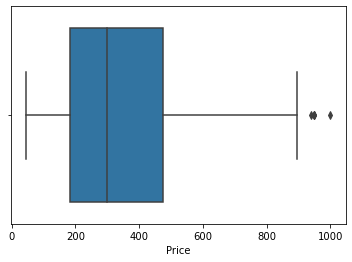

(139, 8)

In [102]:
df = df.drop(columns=['Stream Processors'])
df = df.loc[df['Price'] < 10_000]

df = df[(df != 0).all(1)] # remove empty values

sns.boxplot(df['Price'])
plt.show()

df.describe()
df.shape

The plot looks alot better than before, it still has a few outliers but they will be handled in the next section. The number of data points has gone from 180 to 139.

### Price

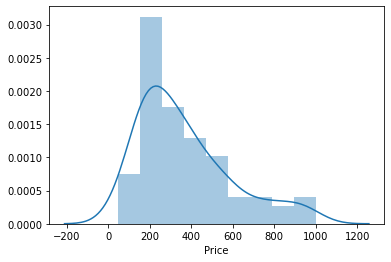

In [103]:
sns.distplot(df['Price'])
plt.show()

The price distribution is quite skewed and there are not many GPUs in this data set with high value. If we cap price at £600 then we see the data gets slightly closer to a normal distribution, which is more ideal for a regression problem. This nearly halves the range of price but only gets rid of ~20 data points. The new box plot also shows no outliers.

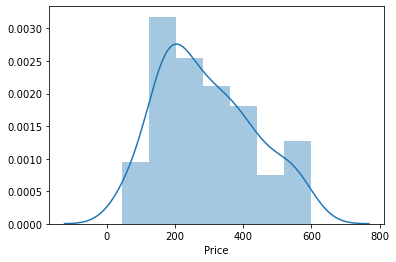

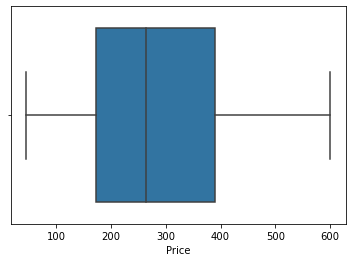

(119, 8)

In [104]:
df = df.drop(df.loc[df['Price'] > 600].index)
sns.distplot(df['Price'])
plt.show()

sns.boxplot(df['Price'])
plt.show()

df.shape

### Thermal Design Power

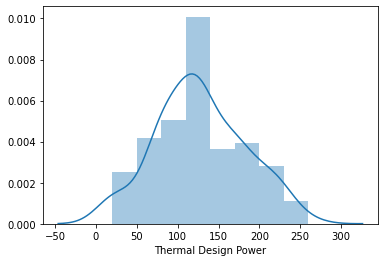

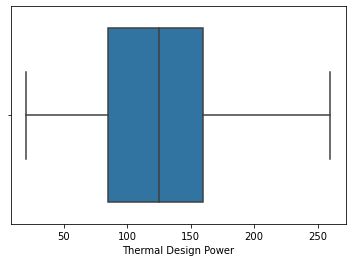

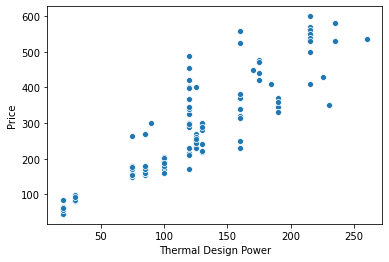

In [105]:
sns.distplot(df['Thermal Design Power'])
plt.show()
sns.boxplot(df['Thermal Design Power'])
plt.show()
sns.scatterplot(df['Thermal Design Power'], df['Price'])
plt.show()

Thermal Design Power (TDP) has a roughly normal distribution and a positive correlation with price. On the surface this seems like a good variable to include in a model, however TDP is not really something that affects performance but is something that is determined by performance. The better a GPU performs the more power it will require. Despite have a strong correlation with price, the goal of this project is to determine GPU price based on performance specs, so TDP is not relevant in this regard.

In [106]:
df = df.drop(columns=['Thermal Design Power'])

We want to predict the price of the graphics card based on the 6 variables we have. However we need to ensure that the varibles satisfy the requirements of a regression problem and we want to omitt variables that may over complicate the model.

In [107]:
df.corr()

,Price,CUDA Cores,Memory Size,Memory Type,Memory Interface,Clock,Series
Price,1.000000,0.890530,0.787628,0.465321,0.850752,0.251611,0.626301
CUDA Cores,0.890530,1.000000,0.921403,0.588712,0.931935,0.418369,0.738759
Memory Size,0.787628,0.921403,1.000000,0.587288,0.899055,0.520825,0.720887
Memory Type,0.465321,0.588712,0.587288,1.000000,0.475559,0.593082,0.594031
Memory Interface,0.850752,0.931935,0.899055,0.475559,1.000000,0.361993,0.568034
Clock,0.251611,0.418369,0.520825,0.593082,0.361993,1.000000,0.490029
Series,0.626301,0.738759,0.720887,0.594031,0.568034,0.490029,1.000000


This correlation table will be referenced later when analysing each feature. below is a heatmap to give a more visual respresentaion. Ideally we would like low correlation between variables.

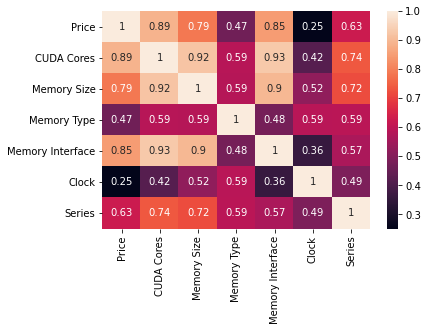

In [108]:
sns.heatmap(df.corr(), annot=True)
plt.show()

### CUDA Cores
CUDA cores are parallel processors, which process all of the data that goes into and out of the GPU. Here we are looking at the number of cores in the graphics card.

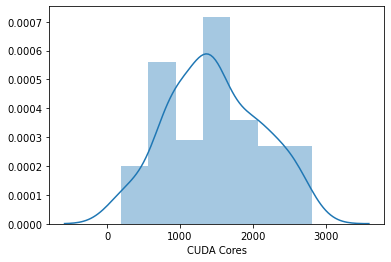

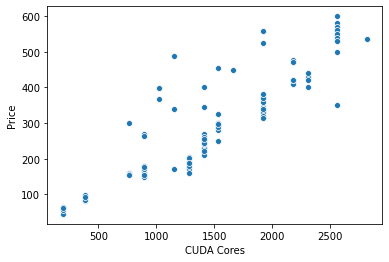

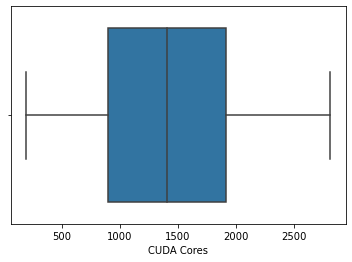

In [109]:
sns.distplot(df['CUDA Cores'])
plt.show()
sns.scatterplot(df['CUDA Cores'], df['Price'])
plt.show()
sns.boxplot(df['CUDA Cores'])
plt.show()

The distribution of CUDA cores is similar to a normal distribution with the exception of a couple of peaks in the middle. It also has a clear positive correlation with price, with roughly linear behaviour. The box plot doesn't show any outliers. 

### Clock Speed

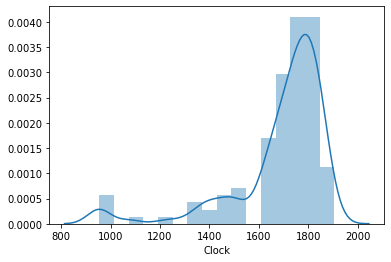

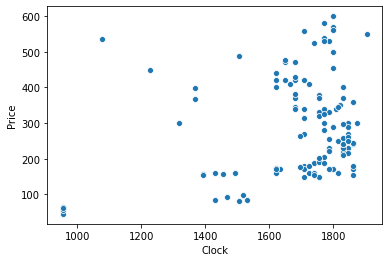

In [110]:
sns.distplot(df['Clock'])
plt.show()
sns.scatterplot(df['Clock'], df['Price'])
plt.show()

The clock speed has a skewed normal distribution with a peak near 1800MHz, but what is surprising here is that it has nearly 0 correlation (0.252) with price. Intuitively a higher clock speed would mean higher performance and thus a higher price, however this is not the case. Is appears as though other factors are alot more significant when determining price.

### Memory

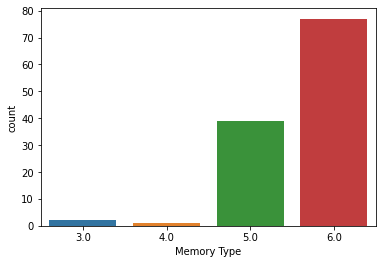

In [111]:
sns.countplot(df['Memory Type'])
plt.show()

GDDR6 is the most common memory type here and is nearly double the amount of the others, so the data is quite unbalanced. This is expected since GDDR6 is the standard for most modern GPUs. It also has a weak correlation with price (0.465) and for these reasons will be omitted from the model.

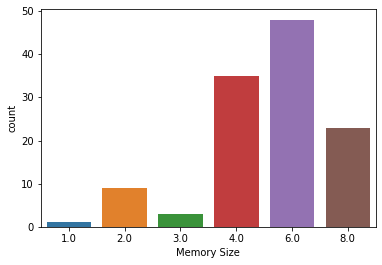

In [112]:
sns.countplot(df['Memory Size'])
plt.show()

Memory size is a very important factor to consider when buying a GPU as it has a significant effect on performance. The data for memory size is a little more balanced for 4GB, 6GB and 8GB memory, but has very few 3GB or below.

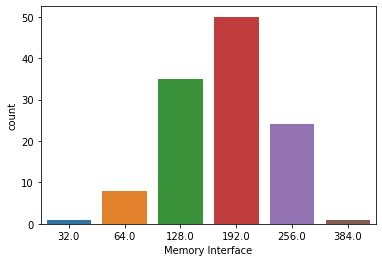

In [113]:
sns.countplot(df['Memory Interface'])
plt.show()

Memory interface is the width of the memory bus through which the graphics data are transferred. The greater the bus width is, the more data the bus can transfer in a clock cycle. This is another important factor that affects the performance of a GPU.

A limitaion is that the dataset does not consist of GPUs with lower end characteristics i.e. low memory size and interface. The correlation between size and interface is 0.899 and the bar charts are very similar in shape, which means that higher quality memory on a GPU will have both a higher size and interface. This means it is only neccessary to include one in our model as it effectively takes into account both. I will choose memory interface because it has a slightly higher correlation with price.

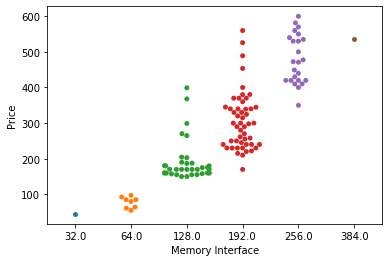

In [114]:
sns.swarmplot(data = df, x='Memory Interface', y='Price')
plt.show()

A swarm plot shows a clear correlation with price aside froma few outliers in 128.0 and 192.0.

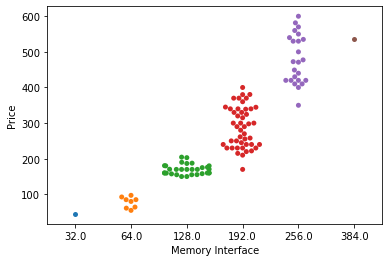

In [115]:
df = df.drop(df.loc[(df['Price'] > 250) & (df['Memory Interface'] == 128.0)].index)
df = df.drop(df.loc[(df['Price'] > 400) & (df['Memory Interface'] == 192.0)].index)

sns.swarmplot(data = df, x='Memory Interface', y='Price')
plt.show()

Removing the outliers gives a much better distribution

## Series
The serires determines the type of micro-architecture of the chip. Very loosely speaking, the newer the series, the more work the chip can do in one cycle.

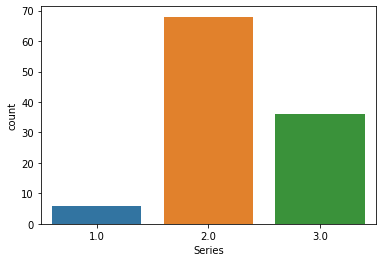

In [116]:
sns.countplot(df['Series'])
plt.show()

Most GPUs in the data set are in the 10 series (class 2) and a significant portion is in the 20 series (class 3). However the data does not contain many GPUs in the 900 series or lower (class 1), meaning that we do not have many older graphics cards. A swarm plot shows the relationship with price.

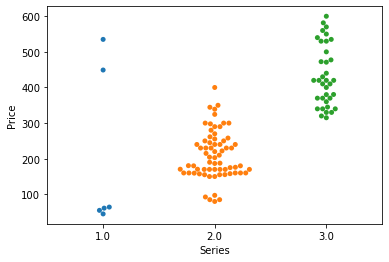

In [117]:
sns.swarmplot(data = df, x='Series', y='Price')
plt.show()

The swarm plot shows a positive correlation with price, with fairly clear price ranges for each series. There are still a few outliers however which can be removed.

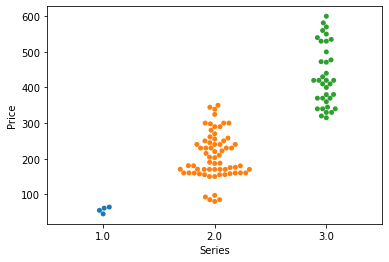

In [118]:
df = df.drop(df.loc[(df['Price'] > 400) & (df['Series'] == 1)].index)
df = df.drop(df.loc[(df['Price'] > 350) & (df['Series'] == 2)].index) 

sns.swarmplot(data = df, x='Series', y='Price')
plt.show()

In [119]:
df = df.drop(columns=['Clock','Memory Type', 'Memory Size'])

# 3. The model

Now that the data has been cleaned and all of the relevant features have been selected, it's time to implement a machine learning model. I think the best choice of model is a random forest regressor because some features in the data are categorical and non-linear. I will use a 80/20 train/test split to train and validate the model.

In [120]:
df.shape

(107, 4)

In [121]:
x = df.iloc[:,1:].values
y = df.iloc[:,:1].values.squeeze(1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(max_depth=5)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

error = (MSE(y_pred,y_test)**(0.5))
    
print('RMSE: £%.2f' % error)

RMSE: £30.09


In [122]:
price = df['Price']
rang = max(price)-min(price)
print('Range of prices: £%.2f' % rang)

Range of prices: £555.00


The model gives an error of around £30 on a test data set. This is small compared to the range of prices, $550. 